# Классифицируем кубы

Это MVP код, поэтому никакой интеграции, без прицела на производительность. Главное быстро получить числа для анализа

In [1]:
import json
import uuid
import datetime
import time
import logging
import itertools
import re
from os import path, listdir, makedirs
from math import isnan
from statistics import mean, StatisticsError
from functools import lru_cache
from collections import Counter

import numpy as np

from nltk.corpus import stopwords
from nltk import FreqDist
import nltk

import pymorphy2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale, Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
plt.rcParams['figure.figsize']=(9,7)
plt.style.use('seaborn-deep')

In [2]:
@lru_cache(maxsize=16384)  # на самом деле, 8192 почти достаточно
def get_normal_form(s):
    return get_normal_form.morph.parse(s)[0].normal_form
get_normal_form.morph = pymorphy2.MorphAnalyzer()  # Лемматизатор

stop_words = set(stopwords.words("russian"))
#stop_words.remove('не')
stop_words.update(set("также иной да нет -".split()))

In [36]:
words_re = re.compile("[а-яёА-ЯЁ]+")
year_re = re.compile(r"\s(\d\d(\d\d)?)\s")
def preprocess(s: str):
    """Возвращает массив токенов по строке"""
    not_process = set(["текущийгод", "нетекущийгод"])
    s = s.replace("2017", "текущийгод")
    s = s.replace("17", "текущийгод")
    s = year_re.sub(" нетекущийгод ", s + " ")
    return tuple(set(map(
        lambda x: get_normal_form(x) if x not in not_process else x,
        filter(
            lambda x: x not in stop_words,
            words_re.findall(s.lower())
        )
    )))


preprocess("хорошо жить в 2017 году 19 после 2016")

('текущийгод', 'год', 'жить', 'нетекущийгод')

In [29]:
year_re.sub(" текущийгод ", "хорошо жить в 2017 году 19 после 2016 ")


'хорошо жить в текущийгод году текущийгод после текущийгод '

Загрузим данные

In [37]:
def get_test_files(test_path, prefix):
    for file_name in listdir(test_path):
        if file_name.startswith(prefix):
            yield path.join(test_path, file_name)

In [38]:
cube_re = re.compile(r'(?<=FROM \[)\w*')

CubesMap = {}

lines = []
for test_path in get_test_files('../tests/cube/', "cubes_test"):
    with open(test_path, 'r', encoding='utf-8') as file_in:
        for idx, line in enumerate(file_in):
            line = line.strip()
            if not line:
                continue

            if line.startswith('*'):
                continue

            req, answer = line.split(':')
            answer = cube_re.search(answer).group()
            
            if not answer in CubesMap:
                if not CubesMap:
                    CubesMap[answer] = 0
                else:
                    CubesMap[answer] = max(CubesMap.values()) + 1
                    
            answer = CubesMap[answer]
            req = req.lower()
            req = preprocess(req)
            lines.append((req, answer))

BackCubesMap = {CubesMap[i]:i for i in CubesMap}
            
print("Всего: {} примеров".format(len(lines)))
print("Первая строка: {}".format(lines[0]))
print(json.dumps(CubesMap,indent=4))

Всего: 406 примеров
Первая строка: (('страна', 'январь', 'текущийгод', 'клуб', 'войти', 'парижский', 'задолженность'), 0)
{
    "FSYR01": 1,
    "INDO01": 3,
    "EXDO01": 2,
    "CLMR02": 0,
    "CLDO02": 7,
    "CLDO01": 4,
    "INYR03": 5,
    "EXYR03": 6
}


Построим большой словарь со всеми частотами, а затем его гистограмму

Всего 299 слова. Из них значимых не более 165
Самые частые слова
год 196
бюджет 165
доход 132
расход 107
нетекущийгод 103
область 86
исполнение 66
консолидированный 63
текущийгод 62
федеральный 52
сколько 48
текущий 43
долг 36
рф 35
федерация 35
российский 35
вологодский 33
сумма 31
поступление 27
субъект 26


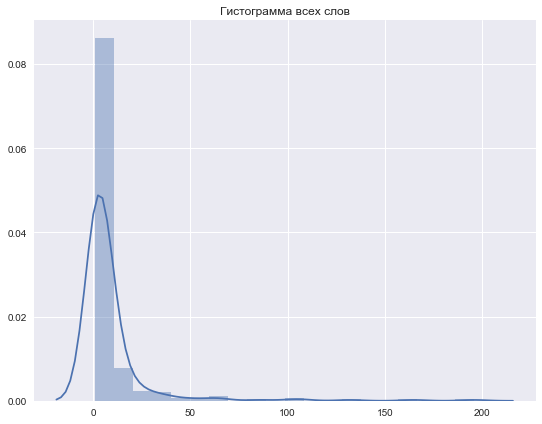

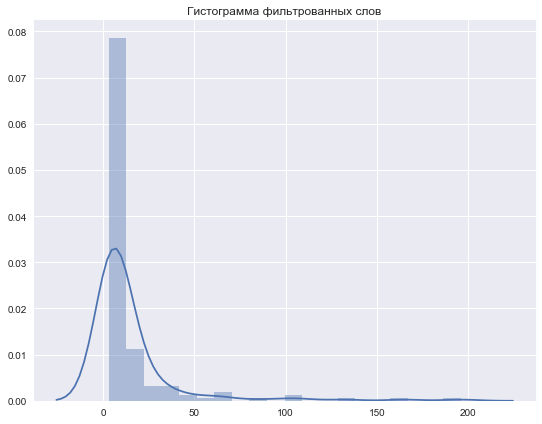

In [39]:
all_freqs = Counter()
for line in lines:
    for word in line[0]:
        all_freqs[word] += 1
print("Всего {} слова. Из них значимых не более {}".format(
    len(all_freqs),
    len(list(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())))
))
print("Самые частые слова")
for word in tuple(sorted(all_freqs.keys(), key = lambda x: all_freqs[x], reverse=True))[:20]:
    print(word, all_freqs[word])
        
sns.distplot(tuple(all_freqs.values()), bins=20)
plt.title("Гистограмма всех слов")
plt.show()

sns.distplot(tuple(filter(lambda x: x >= 3, all_freqs.values())), bins=20)
plt.title("Гистограмма фильтрованных слов")
plt.show()

Построим соответствие между словами и их индексами в векторе

In [40]:
WordIndex = {}
for ind, word in enumerate(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())):
    WordIndex[word] = ind

In [41]:
X = np.zeros((len(lines),len(WordIndex)))
Y = np.zeros(len(lines))

used_queries = set()
filtered_data = []
    
for line in lines:
    stringed_example = "".join(sorted(line[0]))
    if stringed_example in used_queries:
        continue
    used_queries.add(stringed_example)
    filtered_data.append(line)

print("Отфильтровали {} примеров".format(len(lines) - len(filtered_data)))

X = np.zeros((len(filtered_data),len(WordIndex)))
Y = np.zeros(len(filtered_data))

for ind, line in enumerate(filtered_data):
    req_words = line[0]
    for word in req_words:
        if word not in WordIndex:
            continue
        X[ind,WordIndex[word]] += 1
    Y[ind] = line[1]

print(X.shape[0])
# Нормализация среднего и среднеквадратичного отклонения
scaler = StandardScaler()
X = scaler.fit_transform(X)

Отфильтровали 84 примеров
322


Несмотря на кажущуюся примитичность, цифра ниже показывает максимальную теоритическую точность при использовании логистической регрессии. Реальная точность будет другой. Так её проверять **НЕЛЬЗЯ**

In [42]:
clf = LogisticRegression().fit(X,Y)
(clf.predict(X) == Y).sum() / Y.shape[0]

0.99689440993788825

Препроцессинг уже матрицы

In [44]:
def getClassifier():
    classifiers = {
        "SVM": (SVC, ParameterGrid({"C":[1,4,10], "probability":[True], "decision_function_shape":["ovr"]})),
        "logistic": (LogisticRegression, ParameterGrid({"C":[1,2], "n_jobs":[-1]})),
        "GB": (GradientBoostingClassifier, ParameterGrid({
            "learning_rate":[0.3, 0.1],
            "n_estimators":[100, 240],
            "max_depth": [1,2,3]
        }))
    }
    for clf_name in classifiers:
        for params in classifiers[clf_name][1]:
            yield clf_name, params, classifiers[clf_name][0](**params)

Далее я вставил *свой* сниппет, который делает следующее: использует K-Fold с общими тестами, проверяет метрики на каждой из моделей. Затем выводит максимальные и минимальные результаты

Чем больше KFOLD_PARTS, тем точнее к реальной жизни, но тем дольше. При $parts \rightarrow N$ получим 1-Fold и супер низкую скорость

Так как
$$\frac{N}{parts} \ll 100$$
то нахождение доверительного интервала не особо осмысленно

In [45]:
KFOLD_PARTS = 40

kf = KFold(n_splits=KFOLD_PARTS,shuffle=True,random_state=42)

# сюда положим точность по кубам
CubesAcc = {i:{"T":0, "F": 0} for i in CubesMap.values()}
conf_matr = np.zeros((len(CubesMap), len(CubesMap)))

best_clf_name = None
best_params = None
best_acc = 0
best_y_test_pred = None
best_y_test_pred_proba = None
best_y_test_real = None

for clf_name, params, clf in getClassifier():
    y_train_pred = np.array([])
    y_train_real = np.array([])

    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0,len(CubesMap)))
    y_test_real = np.array([])
    
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index]

        X_test = X[test_index]
        Y_test = Y[test_index]

        clf.fit(X_train,Y_train)

        y_train_pred = np.concatenate((y_train_pred, clf.predict(X_train)))
        y_train_real = np.concatenate((y_train_real, Y_train))
        
        y_test_pred = np.concatenate((y_test_pred, clf.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, clf.predict_proba(X_test)))
        y_test_real = np.concatenate((y_test_real, Y_test))
    
    if log_loss(y_test_real, y_test_pred_proba) > best_acc:
        best_clf_name = clf_name
        best_params = params
        best_acc = accuracy_score(y_test_pred, y_test_real)
        best_y_test_pred = y_test_pred
        best_y_test_pred_proba = y_test_pred_proba
        best_y_test_real = y_test_real
    
    print("{} {} and train_acc: {:.3f} test_acc: {:.3f} test_log_loss {:.3f}".format(
        clf_name,
        params,
        accuracy_score(y_train_pred, y_train_real),
        accuracy_score(y_test_pred, y_test_real),
        log_loss(y_test_real, y_test_pred_proba)
    ))
print("Лучший {} {} с acc: {:.3f}".format(
    best_clf_name,
    best_params,
    best_log_loss
))

GB {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 1} and train_acc: 0.989 test_acc: 0.882 test_log_loss 0.409
GB {'n_estimators': 240, 'learning_rate': 0.3, 'max_depth': 1} and train_acc: 0.997 test_acc: 0.866 test_log_loss 0.496
GB {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 2} and train_acc: 1.000 test_acc: 0.904 test_log_loss 0.410
GB {'n_estimators': 240, 'learning_rate': 0.3, 'max_depth': 2} and train_acc: 1.000 test_acc: 0.904 test_log_loss 0.460
GB {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 3} and train_acc: 1.000 test_acc: 0.901 test_log_loss 0.468
GB {'n_estimators': 240, 'learning_rate': 0.3, 'max_depth': 3} and train_acc: 1.000 test_acc: 0.907 test_log_loss 0.448
GB {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 1} and train_acc: 0.957 test_acc: 0.851 test_log_loss 0.550
GB {'n_estimators': 240, 'learning_rate': 0.1, 'max_depth': 1} and train_acc: 0.980 test_acc: 0.882 test_log_loss 0.421
GB {'n_estimators': 100, 'learning_rate'

NameError: name 'best_log_loss' is not defined

In [46]:
print(classification_report(best_y_test_real, best_y_test_pred, target_names=tuple(BackCubesMap.values())))

             precision    recall  f1-score   support

     CLMR02       1.00      0.97      0.99        76
     FSYR01       0.91      1.00      0.95        21
     EXDO01       0.82      0.89      0.85        36
     INDO01       0.72      0.78      0.75        37
     CLDO01       0.89      0.91      0.90        54
     INYR03       0.89      0.86      0.87        28
     EXYR03       0.94      0.87      0.90        38
     CLDO02       0.76      0.69      0.72        32

avg / total       0.88      0.88      0.88       322



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", size=14)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = tuple(BackCubesMap.values())


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matr, classes=class_names,
                      title='Confusion matrix, without normalization')
np.set_printoptions(precision=2)
plt.savefig("/tmp/conf.png")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/tmp/conf_normed.png")
plt.show()

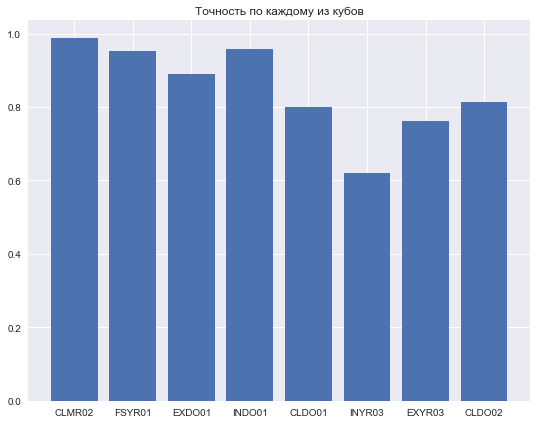

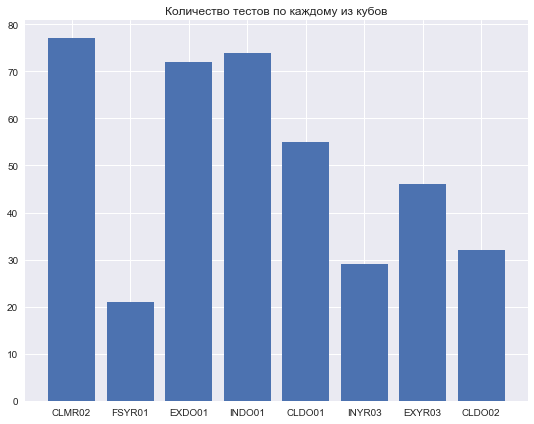

Всего 406 тестов


In [19]:
ind = np.arange(len(CubesAcc))
plt.bar(ind, tuple(CubesAcc.values()))
plt.xticks(ind, BackCubesMap.values())
plt.title("Точность по каждому из кубов")
plt.savefig("/tmp/per_cube_acc.png")
plt.show()

CubesCount = Counter()
for cube_ind in Y:
    CubesCount[cube_ind] += 1
plt.bar(ind, tuple(CubesCount.values()))
plt.xticks(ind, BackCubesMap.values())
plt.title("Количество тестов по каждому из кубов")
plt.savefig("/tmp/per_cube_count.png")
plt.show()

print("Всего {} тестов".format(Y.shape[0]))

In [117]:
def getCubeFromStr(req, clf):
    req = req.lower()
    X = np.zeros((1, len(WordIndex)))
    req_words = preprocess(req)
    words_to_print = []
    for word in req_words:
        if word not in WordIndex:
            continue
        words_to_print.append(word)
        X[0,WordIndex[word]] += 1
    X = scaler.transform(X)
    print(words_to_print)
    return list(map(lambda x: (BackCubesMap[x[0]], x[1]), sorted(list(enumerate(clf.predict_proba(X)[0].tolist())), key = lambda x: x[1], reverse = True)))

In [121]:
clf = GradientBoostingClassifier(learning_rate=0.03,n_estimators = 240,).fit(X,Y)

In [40]:
BackCubesMap

{0: 'CLMR02',
 1: 'FSYR01',
 2: 'EXDO01',
 3: 'INDO01',
 4: 'CLDO01',
 5: 'INYR03',
 6: 'EXYR03',
 7: 'CLDO02'}

In [122]:
s = """Поступления по НДФЛ в бюджеты городских округов Ярославской области"""
getCubeFromStr(s, clf)

['поступление', 'ндфл', 'бюджет', 'городской', 'округ', 'ярославский', 'область']


[('CLDO02', 0.5763299021503253),
 ('INDO01', 0.23120019922729695),
 ('INYR03', 0.13473813687433034),
 ('EXDO01', 0.024093159826190334),
 ('EXYR03', 0.018635905836717984),
 ('FSYR01', 0.008221785670740559),
 ('CLMR02', 0.0034437340219189536),
 ('CLDO01', 0.00333717639247954)]